In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import StackingClassifier

In [12]:
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")

In [13]:
df_fake["class"] = 0
df_true["class"] = 1

In [14]:
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

In [15]:
df = pd.concat([df_fake, df_true], axis=0).reset_index(drop=True)

df = df.sample(frac=1).reset_index(drop=True)

df = df[['text', 'class']] 

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    text = text.lower()
    
    text = re.sub(r'\d+', '', text)
    
    text = text.strip()
    
    return text

df['text'] = df['text'].apply(clean_text)

X = df['text']  
Y = df['class']  

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [16]:
#TfIdf Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [29]:
# Evaluation
def evaluation(model, y_pred):
    accuracy = accuracy_score(Y_test, y_pred)
    conf_matrix = confusion_matrix(Y_test, y_pred)
    class_report = classification_report(Y_test, y_pred)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:\n", class_report)

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [30]:
#testing samples
def testing(model):
    sample_data = df.sample(5)
    sample_tfidf = vectorizer.transform(sample_data['text'])
    sample_pred = model.predict(sample_tfidf)

    for i, (text, label, pred) in enumerate(zip(sample_data['text'], sample_data['class'], sample_pred)):
        print(f"Sample {i+1}:\nText: {text[:150]}...\nActual Class: {'True' if label == 1 else 'Fake'}\nPredicted Class: {'True' if pred == 1 else 'Fake'}\n")

Accuracy: 93.84%
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      5885
           1       0.93      0.94      0.94      5340

    accuracy                           0.94     11225
   macro avg       0.94      0.94      0.94     11225
weighted avg       0.94      0.94      0.94     11225



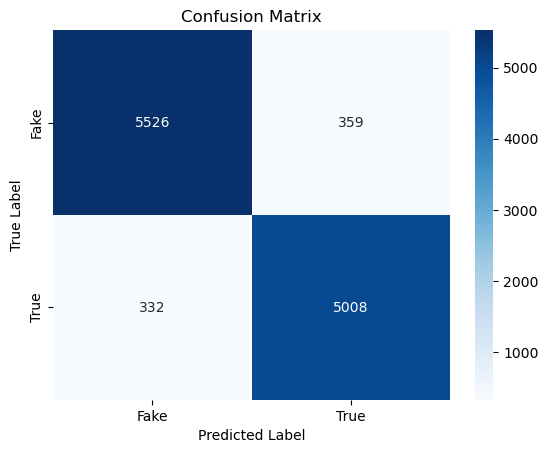

In [19]:
# Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, Y_train)

y_pred_nb = nb_model.predict(X_test_tfidf)

evaluation(model=nb_model, y_pred=y_pred_nb)

Accuracy: 98.26%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      5885
           1       0.98      0.98      0.98      5340

    accuracy                           0.98     11225
   macro avg       0.98      0.98      0.98     11225
weighted avg       0.98      0.98      0.98     11225



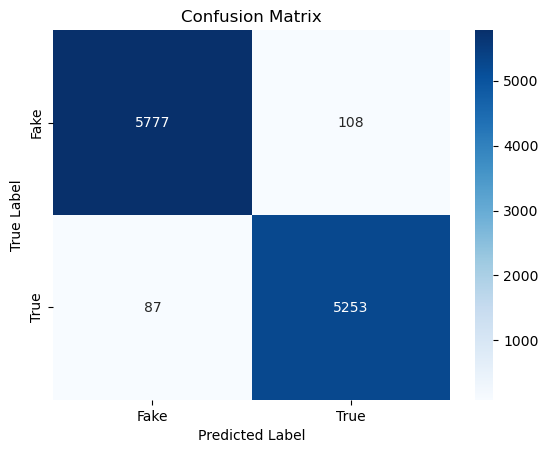

In [20]:
# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_tfidf, Y_train)

y_pred_logistic = logistic_model.predict(X_test_tfidf)

evaluation(model=logistic_model, y_pred=y_pred_logistic)

Accuracy: 99.76%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5885
           1       1.00      1.00      1.00      5340

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



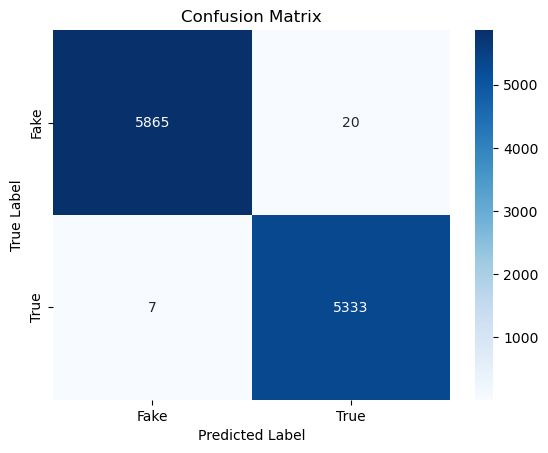

In [23]:
#xgboost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_tfidf, Y_train)

y_pred_xgb = xgb_model.predict(X_test_tfidf)

evaluation(model=xgb_model, y_pred=y_pred_xgb)

Accuracy: 99.79%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5885
           1       1.00      1.00      1.00      5340

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



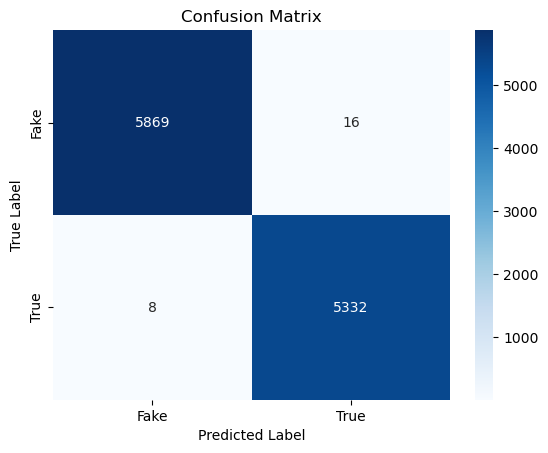

In [27]:
metal_model = StackingClassifier(
    estimators=[
        ('nb', nb_model),
        ('lr', logistic_model),
        ('xgb', xgb_model)
    ],
    final_estimator=LogisticRegression()  
)

metal_model.fit(X_train_tfidf, Y_train)

y_pred_mm = metal_model.predict(X_test_tfidf)

evaluation(model=metal_model, y_pred=y_pred_mm)

In [31]:
testing(model=metal_model)

Sample 1:
Text: it s hard to believe that business mogul donald trump is not only in the presidential race but actually leading the republican candidates apparently h...
Actual Class: Fake
Predicted Class: Fake

Sample 2:
Text: washington reuters  jan  reuters  highlights of the day for us president donald trump’s administration on sunday trump fights back amid international ...
Actual Class: True
Predicted Class: True

Sample 3:
Text: washington reuters  presidential candidate donald trump on wednesday lashed out at the us chamber of commerce’s scathing criticism of his stance on tr...
Actual Class: True
Predicted Class: True

Sample 4:
Text: washington reuters  republican presidential candidate donald trump said he is willing to tap into his personal funds to cover any fundraising deficit ...
Actual Class: True
Predicted Class: True

Sample 5:
Text: loretta lynch is much like obama in that they both feel the ends justifies the means if it s for their political ideology the eternally 